In [1]:
%matplotlib inline
from pathlib import Path
from sklearn.metrics import auc
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from sklearn.naive_bayes import MultinomialNB
from dmba import liftChart, gainsChart

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('/Users/mgpel/OneDrive/Jupyter/DMBA-R-datasets/')

NAIVE BAYES CLASSIFIER APPLIED TO FLIGHT DELAYS (TRAINING) DATA

In [3]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
delays_df



,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime


In [4]:
#naive bayes must convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')
delays_df['Flight Status'] = delays_df['Flight Status'].astype('category')

In [5]:
#create hourly bins for departure times
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')


In [6]:
predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'
# partition data
X = pd.get_dummies(delays_df[predictors])
y = delays_df['Flight Status'].astype('category')
classes = list(y.cat.categories)

In [7]:
#split into training and validation sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

In [8]:
#run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(train_X, train_y)

MultinomialNB(alpha=0.01)

In [9]:
#predict probabilites
predProb_train = delays_nb.predict_proba(train_X)
predProb_valid = delays_nb.predict_proba(valid_X)

In [10]:
#predict class membership
y_train_pred = delays_nb.predict(train_X)
y_valid_pred = delays_nb.predict(valid_X)

PIVOT TABLE OF FLIGHT STATUS BY DESTINATION ARITPORT (TRAINING DATA)

In [11]:
#split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=.4, random_state=1)

pd.set_option('precision', 4)
#probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()


for predictor in predictors:
    #construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)
    
    #divide each value by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x:x / sum(x), axis=1)
    print(propTable)
    print()
pd.reset_option('precision')

ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME        6       7       8       9      10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

SCORING EXAMPLE FLIGHT (PROBABILITY CLASS)

In [12]:
#classify a specific flight by searching in the dataset
#for a flight with same predictor values

df = pd.concat([pd.DataFrame({'actual':valid_y,  'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=valid_y.index)], axis=1)
mask = ((valid_X.CARRIER_DL == 1) & (valid_X.DAY_WEEK_7 == 1) &
        (valid_X.CRS_DEP_TIME_10 ==1) & (valid_X.DEST_LGA == 1) &
        (valid_X.ORIGIN_DCA == 1))
df[mask]

,actual,predicted,0,1
1225,ontime,ontime,0.057989,0.942011


CONFUSION MATRICES

In [13]:
#training
classificationSummary(train_y, y_train_pred, class_names=classes)

#validation
classificationSummary(valid_y, y_valid_pred, class_names= classes)


Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual delayed  ontime
delayed      52     209
 ontime      61     998
Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual delayed  ontime
delayed      26     141
 ontime      51     663


CUMULATIVE GAINS CHART OF NAIVE BAYES CLASSIFIER APPLIED TO FLIGHT DELAYS DATA

<AxesSubplot:xlabel='# records', ylabel='# cumulative gains'>

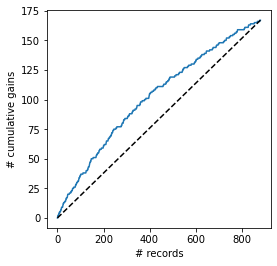

In [14]:
df = pd.DataFrame({'actual': 1 - valid_y.cat.codes,  'prob': predProb_valid[:,0]})
df = df.sort_values(by=['prob'], ascending=False).reset_index(drop=True)
                  
fig, ax = plt.subplots()
fig.set_size_inches(4,4)
gainsChart(df.actual, ax=ax)